# Keras Vision: YOLO (You Only Look Once) Object Detection

In this notebook, I will use computer vision (CV) object detection techniques from the keras machine learning library to classify fashion product image data from the Fashion-MNIST dataset. In this section, I will be building a pretrained CV model.

## Imports

In [1]:
# loads the libraries used in this notebook
! pip install tensorflow_text
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [2]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.3 MB/s eta 0:00:00


In [3]:
os.environ["KERAS_BACKEND"] = "torch"  # I will be using torch as it is a dependency in our environment.yml
import keras
import keras_cv
import tensorflow_datasets as tfds

In [60]:
! pip install datasets
import datasets
import json
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix

## The Data
Much of this data preprocessing was done in the custom section, but I believe we can reapply it in this section given a pretrained model that expects input to be RGB-like image data. Since the fashion-mnist dataset is grayscale the shape differs and must be preprocessed.

In [5]:
fashion_mnist = datasets.load_dataset('fashion_mnist')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
train_fashion_ds = pd.DataFrame(fashion_mnist['train'])
test_fashion_ds = pd.DataFrame(fashion_mnist['test'])
train_fashion_ds.head()

,image,label
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,9
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,3
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0


In [7]:
def convert_to_ds(feature):
    labels = []
    images = []
    def prepare_label_data(image, label, num_labels):
        images.append(np.array(image))
        labels.append(tf.one_hot(label, num_labels))
    feature.apply(lambda x: prepare_label_data(x['image'], x['label'], 10), axis=1)
    X_ds = tf.data.Dataset.from_tensor_slices(images)
    y_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip(X_ds, y_ds)

In [8]:
train_fashion_xy = convert_to_ds(train_fashion_ds)
test_fashion_xy = convert_to_ds(test_fashion_ds)

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
num_classes=10

In [10]:
resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)

In [11]:
def package_inputs(image, label):
    # Duplicate the channel to create a 3-channel image
    rgb_image = tf.image.grayscale_to_rgb(tf.expand_dims(image, axis=-1))
    image = tf.cast(rgb_image, tf.float32)
    return {"images": resizing(image), "labels": label}

In [12]:
train_fashion_xy = train_fashion_xy.map(package_inputs, num_parallel_calls=AUTOTUNE)
test_fashion_xy = test_fashion_xy.map(package_inputs, num_parallel_calls=AUTOTUNE)

In [13]:
train_fashion_xy = train_fashion_xy.ragged_batch(BATCH_SIZE)
test_fashion_xy = test_fashion_xy.ragged_batch(BATCH_SIZE)

In [14]:
batch_train_sample = next(iter(train_fashion_xy.take(1)))
image_batch_sample = batch_train_sample["images"]
label_batch_sample = batch_train_sample["labels"]

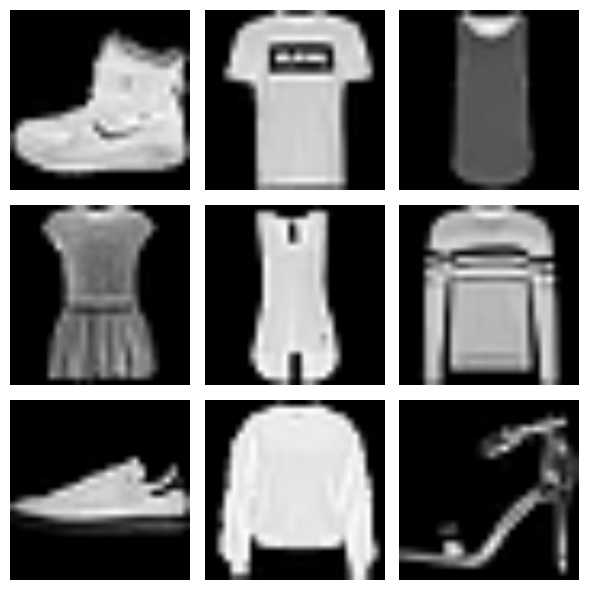

In [15]:
keras_cv.visualization.plot_image_gallery(
    image_batch_sample,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [16]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]


train_fashion_xy = train_fashion_xy.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
test_fashion_xy = test_fashion_xy.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

## The Keras Vision YOLO Object Detection Model

### Inference with a Pretrained Classifier

In [22]:
efficient_net_imageclassifier = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet_classifier"
)

In [18]:
predictions = efficient_net_imageclassifier.predict(train_fashion_xy)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 60s 27ms/step


In [23]:
classes = keras.utils.get_file(
    origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json"
)

33567/33567 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
with open(classes, "rb") as f:
    classes = json.load(f)

In [28]:
def convert_to_label(prediction):
  top_classes = prediction.argsort(axis=-1)
  top_prediction = classes[str(top_classes[-1])]
  return top_prediction

In [29]:
label_predictions = [convert_to_label(pred) for pred in predictions]

In [32]:
train_fashion_ds['efficient_net_prediction'] = label_predictions

In [33]:
clothing_labels = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

In [34]:
train_fashion_ds['true_label'] = train_fashion_ds['label'].apply(lambda x: clothing_labels[x])

In [53]:
train_fashion_ds.sample(10).loc[:,['true_label', 'efficient_net_prediction']]

,true_label,efficient_net_prediction
41998,Ankle boot,"cleaver, meat cleaver, chopper"
13740,Dress,spatula
18381,Ankle boot,"oboe, hautboy, hautbois"
56057,Dress,"oboe, hautboy, hautbois"
20075,Trouser,hair spray
57342,Sandal,spatula
4455,T-shirt/top,"jersey, T-shirt, tee shirt"
52885,Shirt,trench coat
38282,Bag,whiskey jug
29814,Sandal,"cleaver, meat cleaver, chopper"


### Finetuning a Pretrained Classifier

In [38]:
efficient_net_image_backbone = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet", num_classes=num_classes
)

In [39]:
efficient_net_image_backbone.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

In [41]:
efficient_net_image_backbone.fit(train_fashion_xy)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 276s 108ms/step - accuracy: 0.5856 - loss: 1.4383


In [42]:
finetuned_classifier_preds = efficient_net_image_backbone.predict(test_fashion_xy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step


In [47]:
def convert_to_label_finetuned(prediction):
  top_classes = prediction.argsort(axis=-1)
  top_prediction = clothing_labels[int(top_classes[-1])]
  return top_prediction

In [48]:
finetuned_classifier_preds = [convert_to_label_finetuned(pred) for pred in finetuned_classifier_preds]

In [50]:
test_fashion_ds['efficient_net_finetuned_prediction'] = finetuned_classifier_preds

In [52]:
test_fashion_ds['true_label'] = test_fashion_ds['label'].apply(lambda x: clothing_labels[x])

In [55]:
test_fashion_ds.sample(10).loc[:,['true_label', 'efficient_net_finetuned_prediction']]

,true_label,efficient_net_finetuned_prediction
4919,Bag,Bag
8576,Dress,Dress
7185,Trouser,Trouser
5778,Bag,Bag
8435,Trouser,Trouser
7788,T-shirt/top,T-shirt/top
9531,Pullover,Shirt
7053,T-shirt/top,T-shirt/top
7689,Bag,Bag
8933,Coat,Shirt


In [59]:
f1 = f1_score(test_fashion_ds['true_label'], test_fashion_ds['efficient_net_finetuned_prediction'], average='macro')
accuracy = accuracy_score(test_fashion_ds['true_label'], test_fashion_ds['efficient_net_finetuned_prediction'])
precision = precision_score(test_fashion_ds['true_label'], test_fashion_ds['efficient_net_finetuned_prediction'], average='macro')

In [61]:
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")

F1 Score: 0.82
Accuracy: 0.82
Precision: 0.83


In [62]:
confusion_matrix = confusion_matrix(test_fashion_ds['true_label'],test_fashion_ds['efficient_net_finetuned_prediction'])
confusion_matrix

array([[921,   0,   0,   4,   0,   6,   0,  69,   0,   0],
       [  2, 961,   7,  10,   5,   4,   6,   1,   2,   2],
       [  0,   1, 791,  60,  49,   1,  97,   0,   1,   0],
       [  0,   3,  32, 852,  21,   2,  59,   0,  20,  11],
       [  0,   8, 124,   9, 750,   0, 102,   0,   7,   0],
       [ 25,   0,   0,   0,   0, 888,   0,  86,   1,   0],
       [  0,  24, 206, 100,  65,   1, 437,   0, 165,   2],
       [ 35,   0,   0,   0,   0,  12,   0, 953,   0,   0],
       [  0,  13,  10, 117,  22,   5,  71,   0, 761,   1],
       [  0,   1,   1,  52,   0,   0,   9,   0,   4, 933]])

# Conclusion
It seems like the predictions made with the pretrained 'inference ready' classifier output many more classes than are in the dataset. This meant that although many predictions were 'close', the categorical class being predicted was not 1-1 and so technically wrong. This means further post-processing must be done on the predictions to make evaluations on the success of the model.

The second model did a much better job and was able to classify using the classes provided. This meant it was possible to evalute the success of the model. This model had a f1 score of 82%, which although not perfect, is great given imagenet is trained on full-color images.